In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, callbacks

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

tf.get_logger().setLevel('ERROR')
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('history', exist_ok=True)


IMG_SIZE = 224
INITIAL_EPOCHS = 3
NUM_CLASSES = 101


print(tf.__version__)
tf.config.list_physical_devices("GPU")

2.18.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Feature extraction model

In [15]:
def build_feature_extraction_model(base_model_class, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                   preprocess_layer=None, num_classes=NUM_CLASSES):
    """
    Args:
        base_model_class: A class for the base model (e.g., tf.keras.applications.MobileNet).
        preprocess_layer: Optional preprocessing layer (e.g., tf.keras.layers.Lambda with preprocess function).
        input_shape: The shape of the input data (excluding batch size).
        num_classes: The number of output classes for classification.

    Returns:
        tf.keras.Model: A compiled Keras model.
    """
    if preprocess_layer:
        x = layers.Lambda(preprocess_layer)(layers.Input(shape=input_shape))
        base_model = base_model_class(input_tensor=x, include_top=False, weights="imagenet")
    else:
        base_model = base_model_class(input_shape=input_shape, include_top=False, weights="imagenet")
    
    base_model.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model



def plot_loss_curves(history, title):
    """Return separate loss/accuracy curves for training and validation metrics."""
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(14,4))
    plt.suptitle(title)

    plt.subplot(121)
    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="val loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, accuracy, label="training accuracy")
    plt.plot(epochs, val_accuracy, label="val accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.show()
    

def test_models(models_config, train_data, validation_data, test_data, num_classes=NUM_CLASSES, epochs=INITIAL_EPOCHS):
    """
    Test various models with different configurations and save the results.
    
    Args:
        models_config (list): List of dicts containing model, its name and preprocessor.
        train_data (tf.data.Dataset): Training data.
        val_data (tf.data.Dataset): Validation data.
        num_classes (int): Number of output classes.
        epochs (int): Number of epochs to train the model.
    
    Returns:
        pd.DataFrame: DataFrame with model performance results.
    """
    results = []

    for config in models_config:
        model_class = config['model']
        model_name = model_class.__name__
        preprocess_layer = config['preprocessor']

        checkpoint_callback = callbacks.ModelCheckpoint(f'checkpoints/{model_name}_feature_extraction.keras',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                mode='min',
                                                verbose=0
                                                )

        print(f"Training model: {model_name}...")

        model = build_feature_extraction_model(model_class, preprocess_layer=preprocess_layer)

        history = model.fit(train_data,
                            validation_data=validation_data,
                            epochs=epochs,
                            callbacks=[checkpoint_callback],
                            verbose=0)

        history_data = {'epoch': history.epoch,
                        'history': history.history}
                        
        with open(f'history/{model_name}_feature_extraction.json', 'w') as f:
            json.dump(history_data, f)
        
        val_accuracy = max(history.history["val_accuracy"])
        test_accuracy = model.evaluate(test_data)[1]
        results.append({"Model": model_name,
                        "Validation accuracy": val_accuracy,
                        "Test Accuracy": test_accuracy})

        plot_loss_curves(history, model_name)

    results = pd.DataFrame(results) 
    results.to_csv("feature_extraction_results.csv", index=False)

    return results

In [12]:
train_data, validation_data = image_dataset_from_directory("food101_train",
                                                           image_size=(IMG_SIZE, IMG_SIZE),
                                                           batch_size=32,
                                                           seed=42,
                                                           validation_split=0.1,
                                                           subset="both"
                                                           )

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE)

test_data= (image_dataset_from_directory("food101_test",
                                          batch_size=32,
                                          image_size=(IMG_SIZE, IMG_SIZE),
                                          shuffle=False
                                        )
            .prefetch(buffer_size=tf.data.AUTOTUNE))

Found 74843 files belonging to 101 classes.
Using 67359 files for training.
Using 7484 files for validation.
Found 25255 files belonging to 101 classes.


In [16]:
# `EfficientNetV2S` and `ConvNextTiny` do not require an additional function for preprocessing, which is included in the models.

models_config = [
    {
        'model': applications.MobileNetV2,
        'preprocessor': applications.mobilenet_v2.preprocess_input
    },
    {
        'model': applications.EfficientNetV2S,
        'preprocessor': None
    },
    {
        'model': applications.Xception,
        'preprocessor': applications.xception.preprocess_input,
    },
    {
        'model': applications.ConvNeXtTiny,
        'preprocessor': None,
    },
    {
        'model': applications.ResNet50V2,
        'preprocessor': applications.resnet_v2.preprocess_input,
    }
]

In [18]:
results_df = test_models(models_config, train_data, validation_data, test_data)
results_df.round(2)

,Model,Validation accuracy,Test Accuracy
0,MobileNetV2,0.57,0.62
1,EfficientNetV2S,0.67,0.71
2,Xception,0.55,0.59
3,ConvNeXtTiny,0.65,0.70
4,ResNet50V2,0.53,0.57


# Fine tuning

With mixed precision, only for 2 more promising models.

In [19]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtTiny
from tensorflow.keras.mixed_precision import LossScaleOptimizer

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [26]:
def build_model_for_fine_tuning(base_model_class, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES, unfreezed_layers=10):
    """
    Args:
        base_model_class: A class for the base model (e.g., tf.keras.applications.MobileNet).
        input_shape: The shape of the input data (excluding batch size).
        num_classes: The number of output classes for classification.
        learning_rate: Learning rate for base optimizer (set to 10x lower than the default)

    Returns:
        tf.keras.Model: A compiled Keras model.
    """

    base_model = base_model_class(input_shape=input_shape, include_top=False, weights="imagenet")
    base_model.trainable = False
    for layer in base_model.layers[-unfreezed_layers:]:
        layer.trainable = True
        
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    return model


def compare_histories(name, original_history_history_dict, new_history, initial_epochs=INITIAL_EPOCHS):
    """
    Compares two TensorFlow History objects.
    """
    acc = original_history_history_dict["accuracy"]
    loss = original_history_history_dict["loss"]

    val_acc = original_history_history_dict["val_accuracy"]
    val_loss = original_history_history_dict["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(14, 4))
    plt.suptitle(name)
    
    plt.subplot(1,2,1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and validation accuracy")

    plt.subplot(1,2,2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and validation loss")

    plt.tight_layout()
    plt.show()

In [27]:
early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         mode="min",
                                         patience=3,
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                         factor=0.2,
                                         patience=2,
                                         verbose=1,
                                         min_lr=1e-7)


def fine_tune_models(test_name, train_data, add_epochs=22, learning_rate=0.0001):

    results = []

    for model_class in [EfficientNetV2S, ConvNeXtTiny]:
    
        name = model_class.__name__
        model = build_model_for_fine_tuning(model_class)
        model.load_weights(f'checkpoints/{name}_feature_extraction.keras')

        optimizer = LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=learning_rate))
        
        model.compile(optimizer=optimizer,
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
    
        print(f"Training model: {name}...")
    
        with open(f'history/{name}_feature_extraction.json', 'r') as f:
            old_history = json.load(f)
    
        checkpoint_callback = callbacks.ModelCheckpoint(f'checkpoints/{name}_{test_name}.keras',
                                            monitor='val_loss',
                                            save_best_only=True,
                                            mode='min',
                                            verbose=1
                                            )
    
        history = model.fit(train_data,
                            epochs=INITIAL_EPOCHS + add_epochs,
                            initial_epoch=old_history["epoch"][-1],
                            validation_data=validation_data,
                            callbacks=[checkpoint_callback, early_stopping, reduce_lr],
                            verbose=0)
    
        min_val_loss_index = history.history["val_loss"].index(min(history.history["val_loss"]))
        val_accuracy = history.history["val_accuracy"][min_val_loss_index]
        test_accuracy = model.evaluate(test_data)[1]
        
        results.append({"Model": name,
                        "Validation Accuracy": val_accuracy,
                        "Test Accuracy": test_accuracy})
    
        compare_histories(name, old_history["history"], history)
    
    results = pd.DataFrame(results)
    results.to_csv(f"{test_name}_results.csv", index=False)

    return results

Training model: EfficientNetV2S...

Epoch 3: val_loss improved from inf to 1.13302, saving model to checkpoints/EfficientNetV2S_initial_fine_tuning.keras

Epoch 4: val_loss improved from 1.13302 to 1.08195, saving model to checkpoints/EfficientNetV2S_initial_fine_tuning.keras

Epoch 5: val_loss improved from 1.08195 to 1.05778, saving model to checkpoints/EfficientNetV2S_initial_fine_tuning.keras

Epoch 6: val_loss improved from 1.05778 to 1.03425, saving model to checkpoints/EfficientNetV2S_initial_fine_tuning.keras

Epoch 7: val_loss improved from 1.03425 to 1.02026, saving model to checkpoints/EfficientNetV2S_initial_fine_tuning.keras

Epoch 8: val_loss improved from 1.02026 to 1.01093, saving model to checkpoints/EfficientNetV2S_initial_fine_tuning.keras

Epoch 9: val_loss improved from 1.01093 to 1.00400, saving model to checkpoints/EfficientNetV2S_initial_fine_tuning.keras

Epoch 10: val_loss improved from 1.00400 to 0.99779, saving model to checkpoints/EfficientNetV2S_initial_fi

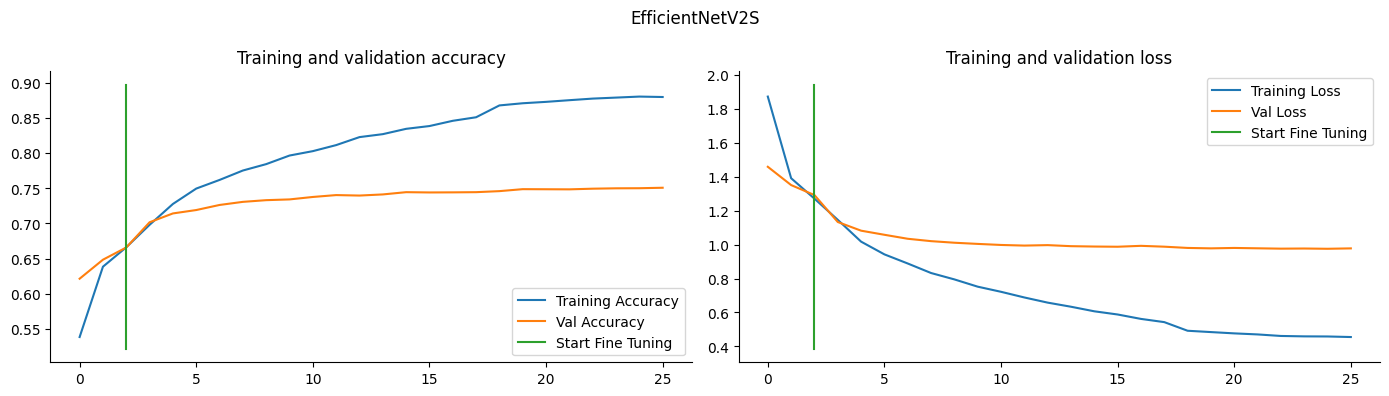

Training model: ConvNeXtTiny...


E0000 00:00:1735925964.367156   33631 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735925964.480699   33631 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735925964.623404   33631 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735925964.737828   33631 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735925964.853054   33631 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0


Epoch 3: val_loss improved from inf to 1.15333, saving model to checkpoints/ConvNeXtTiny_initial_fine_tuning.keras

Epoch 4: val_loss improved from 1.15333 to 1.08235, saving model to checkpoints/ConvNeXtTiny_initial_fine_tuning.keras

Epoch 5: val_loss improved from 1.08235 to 1.04256, saving model to checkpoints/ConvNeXtTiny_initial_fine_tuning.keras

Epoch 6: val_loss improved from 1.04256 to 1.02984, saving model to checkpoints/ConvNeXtTiny_initial_fine_tuning.keras

Epoch 7: val_loss did not improve from 1.02984

Epoch 8: val_loss did not improve from 1.02984

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 9: val_loss did not improve from 1.02984
787/790 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7594 - loss: 0.8643

E0000 00:00:1735926671.696191   33631 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735926671.811004   33631 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


790/790 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.7594 - loss: 0.8641


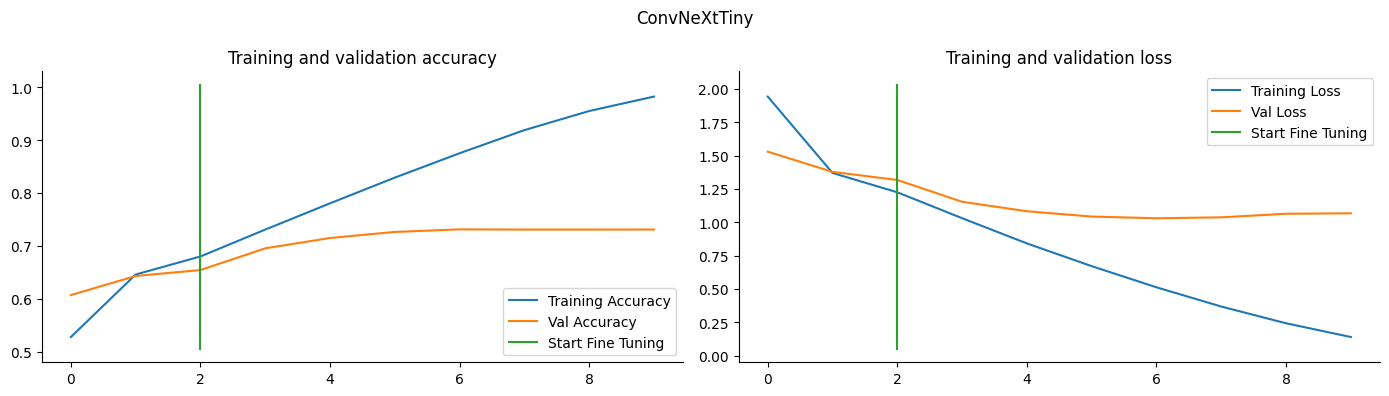

,Model,Validation Accuracy,Test Accuracy
0,EfficientNetV2S,0.749866,0.789309
1,ConvNeXtTiny,0.731160,0.766779


In [28]:
fine_tune_models("initial_fine_tuning", train_data)

# Fine tuning with data augmentation

With multi-thread preprocessing for data augmenation, since the models proved to be prone to overfitting.

In [ ]:
def augment_function(image, label):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.95, upper=1.05)
    
    original_shape = tf.shape(image)
    crop_fraction = 0.9
    crop_height = tf.cast(original_shape[0] * crop_fraction, tf.int32)
    crop_width = tf.cast(original_shape[1] * crop_fraction, tf.int32)
    image = tf.image.random_crop(image, size=[crop_height, crop_width, original_shape[2]])
    
    image = tf.image.resize(image, size=[original_shape[0], original_shape[1]])

    return image, label

train_data_augmented = train_data.map(augment_function, num_parallel_calls=tf.data.AUTOTUNE)
train_data_augmented = train_data_augmented.prefetch(buffer_size=tf.data.AUTOTUNE)

for image, label in train_data_augmented.take(1):
    print("Augmented image shape:", image.shape)
    print("Label:", label)

In [ ]:
fine_tune_models("initial_fine_tuning", train_data_augmented)